# Data normalization

Data normalization means that we want to set the mean and std of each image channel to a set value. 
Usually, the mean is set to 0 and standard deviation to 1. 

1. This keeps the data in the range that the activation function is activated.
2. Also, it makes sure that the distribution in the 3 channels is similar. We want to have learning rate that is appropriate to the different channels.

This should facilitate learning.

The strategy here is as follows:

1. Calculated the mean and standard deviation of the images channels in our dataset.
2. Apply this normalization to our transofrm pipeline when we get images from the dataset.
3. Apply this normalization when we get new images to process (assuming they are coming from the same distribution as those in the dataset).

In this notebook, we will calculate the mean and std of each channel and save the information in the project configuration file for later use.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from torch import optim
import torch
import torch.nn as nn
from datetime import datetime
import albumentations as A
import cv2

from unetTracker.trackingProject import TrackingProject
from unetTracker.multiClassUNetDataset import MultiClassUNetDataset
from unetTracker.unet import Unet

In [9]:
project = TrackingProject(name="faceTrack",root_folder = "/home/kevin/Documents/trackingProjects/")
dataset = MultiClassUNetDataset(image_dir=project.image_dir, mask_dir=project.mask_dir, coordinates_dir=project.coordinates_dir)

Project directory: /home/kevin/Documents/trackingProjects/faceTrack
Loading /home/kevin/Documents/trackingProjects/faceTrack/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_size': [480, 640], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'faceTrack', 'normalization_values': {'means': [129.92483520507812, 117.31977081298828, 121.57162475585938], 'stds': [69.68962860107422, 65.85902404785156, 65.27027893066406]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (128.0, 0.0, 128.0)], 'objects': ['nose', 'chin', 'rEye', 'lEye'], 'target_radius': 10}


## Calculate means and standard deviation of each color channel

We have a function in the dataset class to do just this. It loads all images, calculate the mean per color channel and return it.

In [10]:
means,stds = dataset.get_normalization_values()

In [11]:
print("means:",means)
print("stds:", stds)

means: [129.92484  117.31977  121.571625]
stds: [69.68963  65.859024 65.27028 ]


## Saving normalization values in the project configuration

We can save the normalization values in the project object and to the configuration file.

I am deviding the values by the maximum value for a pixel (usually 255). 

The formula for normalization in the [Albumentations normalization](https://albumentations.ai/docs/api_reference/augmentations/transforms/) function is : `img = (img - mean * max_pixel_value) / (std * max_pixel_value)`

In [13]:
project.set_normalization_values(means/255.0,stds/255.0)
project.normalization_values

{'means': [0.5095091462135315, 0.46007752418518066, 0.4767514765262604],
 'stds': [0.2732926607131958, 0.2582706809043884, 0.2559618651866913]}

In [14]:
project.save_configuration()

Saving /home/kevin/Documents/trackingProjects/faceTrack/config.yalm


In [15]:
project.load_configuration()

Loading /home/kevin/Documents/trackingProjects/faceTrack/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_size': [480, 640], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'faceTrack', 'normalization_values': {'means': [0.5095091462135315, 0.46007752418518066, 0.4767514765262604], 'stds': [0.2732926607131958, 0.2582706809043884, 0.2559618651866913]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (128.0, 0.0, 128.0)], 'objects': ['nose', 'chin', 'rEye', 'lEye'], 'target_radius': 10}


## Apply normalization when training the network

You can apply normalization by setting the transform argument of the dataset. 

Here is an example. 

In [34]:
means = project.normalization_values["means"]
stds = project.normalization_values["stds"]

transform = A.Compose([A.Normalize(mean=means, std=stds)])
transform

Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.5095091462135315, 0.46007752418518066, 0.4767514765262604], std=[0.2732926607131958, 0.2582706809043884, 0.2559618651866913], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

Here is one dataset without normalization and one with normalization.

In [35]:
datasetNoNorm = MultiClassUNetDataset(image_dir=project.image_dir, mask_dir=project.mask_dir, coordinates_dir=project.coordinates_dir)
datasetWithNorm = MultiClassUNetDataset(image_dir=project.image_dir, mask_dir=project.mask_dir, coordinates_dir=project.coordinates_dir,transform=transform)

In [36]:
imgNoNorm,_,_ = datasetNoNorm[0]
imgWithNorm,_,_ = datasetWithNorm[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


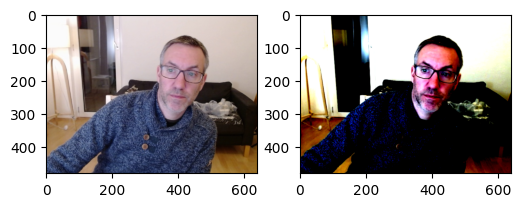

In [37]:
fig,ax = plt.subplots(1,2,figsize=(6,3))
ax[0].imshow(imgNoNorm.permute(1,2,0)/255)
ax[1].imshow(imgWithNorm.permute(1,2,0))
plt.show()